In [120]:
import config_
import pandas as pd
import requests as req
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import scipy
from scipy.stats import pearsonr
from pandas.plotting import register_matplotlib_converters

In [135]:
# requests stock data from alpha vantage api endpoint
def pull_stock_data(symbol, function=None, outputsize=None, datatype=None): 
    
    endpoint = 'https://www.alphavantage.co/query'
    
    if function is None:
        function = 'TIME_SERIES_DAILY'
    if symbol is None:
        return("enter symbol")
    if outputsize is None:
        outputsize = 'compact'
    if datatype is None:
        datatype ='json'
       
    parameters = {
        "function": function,
        "symbol": symbol,
        "outputsize": outputsize,
        "datatype": datatype,
        "apikey": config_.apikey,
        }

    r = req.get(url=endpoint, params=parameters)
    json_dict = r.json()

    return json_dict

# constructs a pandas data frame from json dictionary
def construct_df(json):

    data = json["Time Series (Daily)"]
    
    dates = [major_key for major_key, sub_dict in data.items()]
    opens = [sub_dict["1. open"] for major_key, sub_dict in data.items()]
    highs = [sub_dict["2. high"] for major_key, sub_dict in data.items()]
    lows = [sub_dict["3. low"] for major_key, sub_dict in data.items()]
    closes = [sub_dict["4. close"] for major_key, sub_dict in data.items()]
    volumes = [sub_dict["5. volume"] for major_key, sub_dict in data.items()]

    df = pd.DataFrame({"date": dates, "open": opens, "high": highs, "low": lows, "close": closes, "volume": volumes})
    
    df["date"]= pd.to_datetime(df['date'])
    df["open"] = df["open"].astype(float)
    df["high"] = df["high"].astype(float)
    df["low"] = df["low"].astype(float)
    df["close"] = df["close"].astype(float)
    df["volume"] = df["volume"].astype(int)

    return df

# returns a list of important meta data values 
def meta_data(json):

    symbol = json['Meta Data']['2. Symbol']
    last_refresh = json['Meta Data']['3. Last Refreshed']
    time_zone = json['Meta Data']['5. Time Zone']

    meta_list = [symbol, last_refresh, time_zone]

    return meta_list

# returns a list of daily returns as percentages from 'close' column of dataframe or json dict
def daily_returns(data):
    
    if isinstance(data, pd.DataFrame):
        return [(((x-y)/x)*100) for x, y in zip(df['close'], df['close'][1:])]
    
    if isinstance(data, dict):
        data = data["Time Series (Daily)"]
        closes = [sub_dict["4. close"] for major_key, sub_dict in data.items()]
        closes = list(map(float, closes))
        return [(((x-y)/x)*100) for x, y in zip(closes, closes[1:])]
        
    return("enter json or dataframe")

# returns a dictionary of regression statistics 
def s_regression(y, x=daily_returns(sp_json), plot=False):
    
    # create numpy arrays
    x = np.array(x)
    y = np.array(y)
    y_hist = y
    
    if min(x.size, y.size) < 2000:
        min_length = min(x.size, y.size)
    else:
        min_length = 1095
    
    x= x[:min_length]
    y= y[:min_length]  
    
    # transpose x
    x_T = x.reshape(-1, 1)
    
    # numpy correlation 
    corr = np.corrcoef(x, y)
    
    # adds constant for intercept
    x_matrix = np.vstack([x, np.ones(len(x))]).T
    
    # solves for regression coefficients by computing the inverse of [x_matrix^T dot x_matrix] dot y as column vector
    coefs = (np.linalg.inv(x_matrix.T.dot(x_matrix)).dot(x_matrix.T)).dot(y)
    
    stats = {'sample size': x.size, 'correlation': corr[0][1], 'r-squared': corr[0][1]**2, 'coeficient': coefs[0], 'intercept': coefs[1]}
    
    # plot if true
    if plot: 
        x_plot = np.linspace(min(x_T),max(x_T),x.size)
        y_plot = coefs[1] + coefs[0]*x_plot
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(221)
        ax1.scatter(x, y)
        ax1.plot(x_plot, y_plot, '-r')
        plt.title("Regression Analysis w/ OLS")

        # table
        ax2 = fig.add_subplot(323)
        font_size=12
        bbox=[0, 0, 1, 1]
        ax2.axis('off')
        text = []
        for x, y in stats.items():
            l = []
            l.append(x)
            l.append(str(round(y, 3)))
            text.append(l)
        table = ax2.table(text)
        table.auto_set_font_size(False)
        table.set_fontsize(font_size)
        table.scale(1, 2)
        
        
    if not plot: 
        return stats

# returns histogram of stock returns
def histogram(returns):
    x = np.array(returns)

    num_bins = 100
    fig = plt.figure(figsize=(14,10))
    plt.title("Histogram of Returns")
    n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)


In [98]:
sp = daily_returns(pull_stock_data('sp', outputsize='full'))

In [100]:
stock = daily_returns(pull_stock_data('aapl', outputsize='full'))

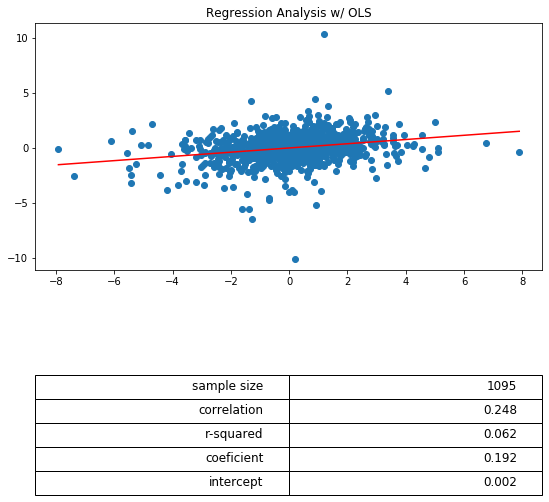

In [132]:
s_regression(dis,sp, plot=True)

In [134]:
dis = daily_returns(pull_stock_data('dis', outputsize='full'))

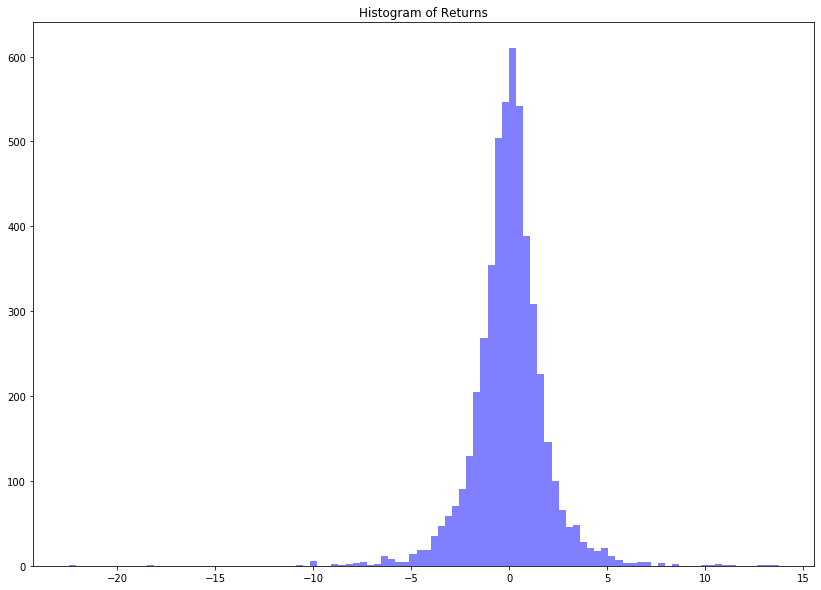

In [133]:
histogram(dis)